# Cohort 4 Screening test solution

The below is an attempt to solve task 1 of the question bank. The solution is being submitted as an individual submission, whereas the application for the mentorship program is being done as a team. 

$\textbf{Author:}$ Vivek Subramaniam R 

$\textbf{Teammate:}$ Ayushi Dubal 

In [11]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit.library import ZGate
from qiskit.quantum_info import Operator
from qiskit.providers.aer.backends import statevector_simulator, qasm_simulator
from qiskit.visualization import plot_state_city, plot_histogram
from qiskit import Aer, execute
import numpy as np


## Step 1:

First, lets find out for a given bitsize what would be the required solutions, since for each bitstring we will have only 2 solutions

In [ ]:
def targets(bitsize):
    state1 = ""
    state2 = ""
    bits = ["0", "1"]
    for i in range(bitsize):
        state1 += bits[i%2]
        state2 += bits[1-(i%2)]
    return state1, state2

## Step 2: State initialisation

We need to initialise our memory bits to what the input vector is, now, we know that Grovers will nt work if we have to search for an equal number of out outcomes in a sample, that is if we have n inputs and n queries, grovers will not work. Hence we pad the input vector upto 8 bits to help up in this case. Since any other input has the potential of becoming an equal output case, we are safer taking 3 address bits as minimum. This is what is done in the Q_ram function as well. 


The function given below gives us the initial state of the vector as one large bitstring

In [ ]:
def state_bin(vector, bitsize):
    state = ""
    for num in vector:
        state += bin(num)[2:].rjust(bitsize,'0')
    return state[::-1]

## Step 3: Control Gate formation

This function is to create a multi-controlZ gate to be used as an oracle to apply the appropriate negative states to the gates we have. The multi-control qubits will take memory bits as the control and target the fan-out bits of the qram

In [ ]:
def controlZ(bitsize):
    ctrlZ = QuantumCircuit(bitsize)
    g1 = ZGate().control(num_ctrl_qubits=bitsize, ctrl_state=targets(bitsize)[0])
    g2 = ZGate().control(num_ctrl_qubits=bitsize, ctrl_state=targets(bitsize)[1])
    return g1, g2

## Step 4: Grovers
This is the grovers diffuser gate that will have to be appended to the circuit the grovers diffuser will pick out those states that have a negative and give it to us. The gorvers circuit will look as follows, the oracle in our case will be the control z gates and the diffuser is defined below
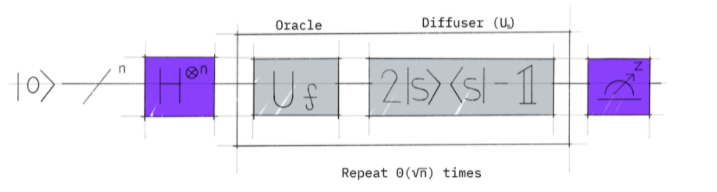

In [12]:
def groversDiffuser(n):
    s = np.array([[1.0/np.sqrt(2**n)] for i in range(2**n)])
    op = np.matmul(s, s.T)
    U_S = Operator((2*op)-np.identity(2**n))
    
    return U_S

## Step 5: Qram and fan-out 

The QRAM provided in the question to us gives us circuits on how exactly to build the bucket-brigade model. This will be used to store and query the elements stored in the QRAM. The below circuit shows the QRAM and the bucket Brigade model.
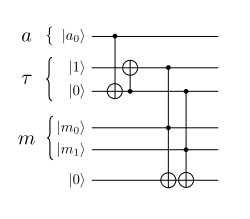
The above shows the QRAM Circuit (this is to show the fanout that aquires the address qubit's character.
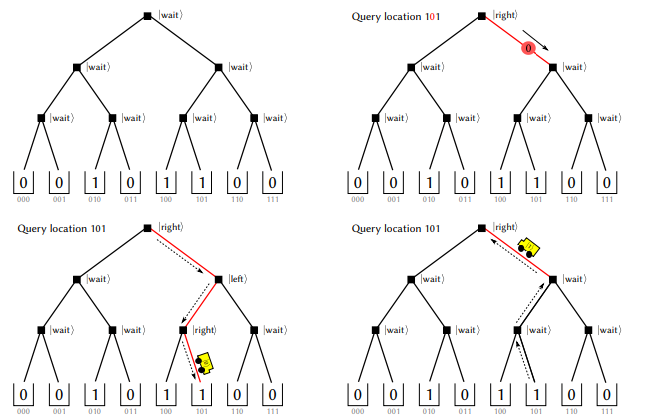
This is a step by step guide of how the data is queried from the memory location

In [16]:
def fanout(n, bitsize):
    address = QuantumRegister(n, 'addr')
    tau = QuantumRegister(2**n, 't')
    
    circ = QuantumCircuit(address, tau)
    
    circ.x(tau[0])
    circ.cx(address[n-1], tau[1])
    circ.cx(tau[1], tau[0])
    
    for i in range(1, n):
        for j in range(2**i):
            circ.ccx(address[n-i-1], tau[j], tau[j+2**i])
        for k in range(2**i):
            circ.cx(tau[k+2**i], tau[k])
    
    gate = circ.to_gate()
    gate.name = "Fanout"
    
    return gate

## Step 6: QRAM and circuit compilation

### State Initialisation
We have taken the bit string of each number, concatenated it into one whole string and then applied X gates appropriately in the circuit to initialise the given vector in our circuit.

### QRAM Construction
Now, finally we get to building the whole qram and quering it, using oracle and attaching the grovers algorithm to finally see the output. We will be using the model of QRAM that has multiple qubits at each memory location and that can store more than a single bit at each location. One thing to note is that the address and the fanout states will get entangled as we initialise the address to all possible states by applying hadamard gates. 
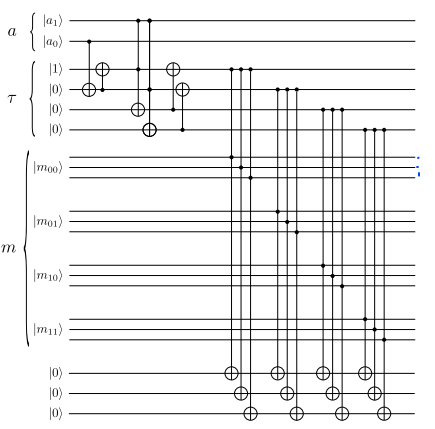

### Applying the oracle 
Now to apply the oracle we have identified the two controlled gates we will require. This way, we can apply the multiple controls to each memory location and target to each individual bit in $ \tau $. This will make sure that which ever memory location that the winner (required number) is will get get a negative sign in the address. This will be the query condition for grovers and entails the amplitude modificaition step. Next we need to use the amplitude amplification step to amplify the required result.

### DIffuser and Measurement 
The diffuser is defined in the previous circuit to amplify the negative phased states in the entire state to get the answer. We then measure the address qubits to get the inidices where the required states our. 

In [54]:
def q_ram(vector):
    
    #Gathering information from given vector, making sure that a circuit has atleast minimum 8 address states
    if len(vector)<=4:
        n = 3
        for i in range(len(vector), 8):
            vector.append(0)
    else:
        n = len(bin(len(vector)-1))-2
    bitsize = len(bin(max(vector))) - 2
    
    #Creating the quantum circuit
    address = QuantumRegister(n, 'addr')
    tau = QuantumRegister(2**n, 't')
    memory = QuantumRegister(bitsize*len(vector), 'mem')
    output = QuantumRegister(bitsize, 'op')
    classicalBit = ClassicalRegister(n, 'clBit')
    
    circ = QuantumCircuit(address,tau,memory,output,classicalBit)
    
    #Initialising the input state of the vector
    state = state_bin(vector, bitsize)
    for count, i in enumerate(state):
        if i == "1":
            circ.x(memory[count])
            
    #Initialise the address state to all possible states
    circ.h(address[0:n])
    
    #Defining the fanout gate and fanoutGate_inverse (to remove entanglement)
    fanoutGate = fanout(n, bitsize)
    fanout_inverse = fanoutGate.inverse()
    temp=[]
    temp.append(address[:])
    temp.append(temp[:])
    
    #Append the fanout gate to the circuit
    circ.append(fanoutGate, range(n+2**n))

    #Now, as in the qram we need to query the memory states with toffoli gates
    for i in range(2**n):
        for j in range(bitsize):
            circ.ccx(tau[i], memory[bitsize*i+j], output[j])
        circ.barrier()
    
    #Get the oracle(controlZGates) and the diffuser 
    cz1, cz2 = controlZ(bitsize)
    groversDiff = groversDiffuser(n)
    
    #apply the oracle to get negative states of the required address locations
    for i in range(2**n):
        qubits=[]
        for j in range(bitsize):
            qubits.append(memory[bitsize*i+j])
        qubits.append(tau[i])
        circ.append(cz1, qubits)
        circ.append(cz2, qubits)
        circ.barrier()
        
    # Applying the fanout to the circuit again to remove entanglement
    circ.append(fanout_inverse, range(n+2**n))
    
    #applying the grovers diffuser to get the final results
    circ.append(groversDiff, range(n))
    circ.barrier()
    
    #Apply the measurement to the circuit
    for i in range(n):
        circ.measure(address[i], classicalBit[i])
    
    
    return circ

## Circuit Visualisation 
Lets see how the circuit looks and we'll notice that the circuit looks just like the QRAM with grovers applied at the end.

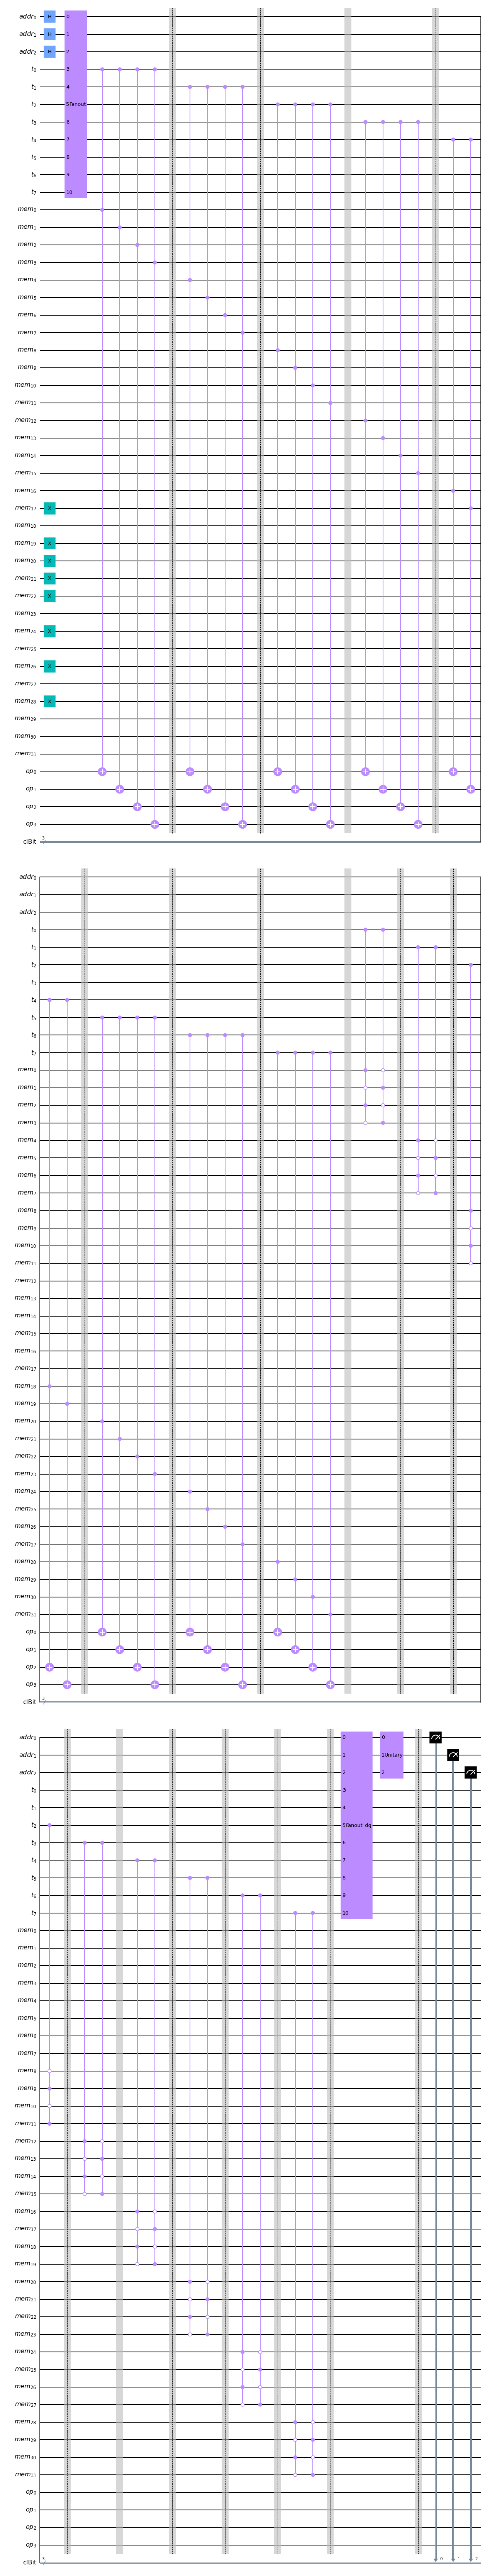

In [57]:
q_ram([1,5,7,10]).draw('mpl')

## Measurement Outcomes 
Now we'll pass an input vector [1,5,4,2] and we will measure the final address bits to see if we get the final required output.


P.S. As we can see below there is a bug in the program that is not making the circuit work exactly as required but the circuit does give us the locations of all the non-zero elements we have provided to the circuit. As we can see from simulation below that, the circuit does not give us a result only for the position of 1 in the input vecotr and not for the 0's

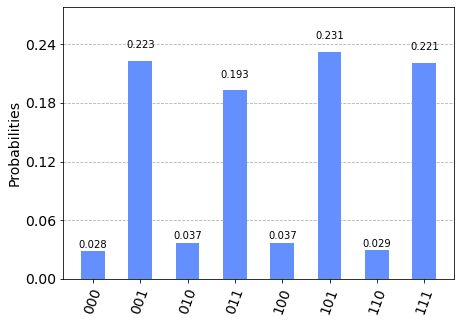

In [58]:
qcirc = q_ram([1,5,7,10])
backend = Aer.get_backend("qasm_simulator")
job = execute(qcirc, backend, shots = 1024)
res = job.result()
counts = res.get_counts()
plot_histogram(counts)

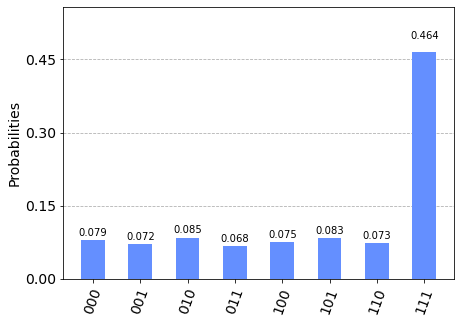

In [55]:
qcirc = q_ram([1,0,0,0])
backend = Aer.get_backend("qasm_simulator")
job = execute(qcirc, backend, shots = 1024)
res = job.result()
counts = res.get_counts()
plot_histogram(counts)